In [487]:
%pylab inline

import pandas as pd
import scipy.stats as stats
import polygon
import tqdm
import seaborn as sns

plt.style.use('seaborn')
rcParams['figure.figsize'] = (12,8)
rcParams['axes.grid'] = True

Populating the interactive namespace from numpy and matplotlib


In [50]:
from importlib import reload
reload(polygon)
api = polygon.REST()

In [340]:
# Get SPX top50 components.
spx = pd.read_csv('data/spx.csv')[:50]
spx.index = spx.Ticker
spx = spx.Weight / spx.Weight.sum()

In [522]:
def download(symbol: str):
    aggs = api.aggs(symbol, 1, 'minute', '2017-03-28', '2022-03-28', limit=50000)
    while aggs.index[-1] <= pd.to_datetime('2022-03-25'):
        s_date = aggs.index[-1] + datetime.timedelta(days=1)
        aggs = aggs.append(api.aggs(symbol, 1, 'minute', s_date.strftime('%Y-%m-%d'), '2022-03-28', limit=50000))
    aggs.index = aggs.index.tz_localize('UTC').tz_convert('US/Eastern')
    aggs = aggs.loc[(aggs.index.time >= datetime.time(9,30)) & (aggs.index.time < datetime.time(16,0))]
    aggs.to_csv(f'data/{symbol}.csv')
    
def download_all():
    for symbol in tqdm.tqdm(spx.index):
        download(symbol)
        
def load_df() -> pd.DataFrame:
    df = pd.read_csv('data/top50.csv', index_col=0)
    df.index = pd.to_datetime(df.index, utc=True).tz_convert('US/Eastern')
    return df
        
def load_data(symbol: str) -> pd.DataFrame:
    aggs = pd.read_csv(f'data/{symbol}.csv', index_col=0)
    aggs.index = pd.to_datetime(aggs.index, utc=True).tz_convert('US/Eastern')
    return aggs
        
def load_all() -> pd.DataFrame:
    df = pd.DataFrame()
    for symbol in tqdm.tqdm(spx.index):
        aggs = load_data(symbol)
        df[symbol] = aggs.c
    return df

def slice_day(df: pd.DataFrame, date) -> pd.DataFrame:
    date = pd.to_datetime(date, utc=True).tz_convert('US/Eastern') + datetime.timedelta(hours=4)
    prior_close = df.loc[:date].dropna().iloc[-1]
    e_date = date + datetime.timedelta(days=1)
    return df.loc[date:e_date] / prior_close

def fit_dispersion(day: pd.DataFrame, t_offset: int = 30):
    disp = ((day - 1.0).pow(2) * spx).sum(axis=1) - (day.SPY - 1.0).pow(2)
    t = (day.index - day.index[0]).total_seconds() / (day.index[-1] - day.index[0]).total_seconds()
    pred = pd.Series([0.0]*len(disp), index=disp.index)[t_offset:]
    slopes = pd.Series([0.0]*len(disp), index=disp.index)[t_offset:]
    for idx in range(t_offset, len(disp)):
        slope, intercept = np.polyfit(2*np.log(t[1:idx]), np.log(disp.iloc[1:idx]), 1)
        slopes[idx-t_offset] = slope
        pred[idx-t_offset] = np.exp(intercept)
        
    theta = pd.Series([0.0]*len(disp), index=disp.index)[:-1]
    for idx in range(len(disp)-1):    
        r1 = (day.iloc[idx] - 1.0)
        r3 = (day.iloc[-1] - 1.0)
        r2 = (day.iloc[-1] / day.iloc[idx] - 1.0)
        wr1 = (r1 * spx).dropna()
        wr2 = (r2 * spx).dropna()
        theta[idx] = np.arccos(wr1.values.dot(wr2.values) / np.sqrt(wr1.pow(2).sum() * wr2.pow(2).sum()))
    return disp, pred, slopes, theta

def hedge_pnl(day: pd.DataFrame):
    disp = ((day - 1.0).pow(2) * spx).sum(axis=1) - (day.SPY - 1.0).pow(2)
    pnls = pd.Series([0.0]*len(disp), index=disp.index)
    for idx in range(len(disp)):
        intra = day.iloc[-1] / day.iloc[idx]
        intra = ((intra - 1.0)**2 * spx).sum() - (intra.SPY - 1.0)**2
        pnls[idx] = disp[idx] + intra - disp[-1]
    return pnls

In [523]:
df = load_df()

In [524]:
day = slice_day(df, '2022-03-23')

In [525]:
disp, pred, slopes, theta = fit_dispersion(day)

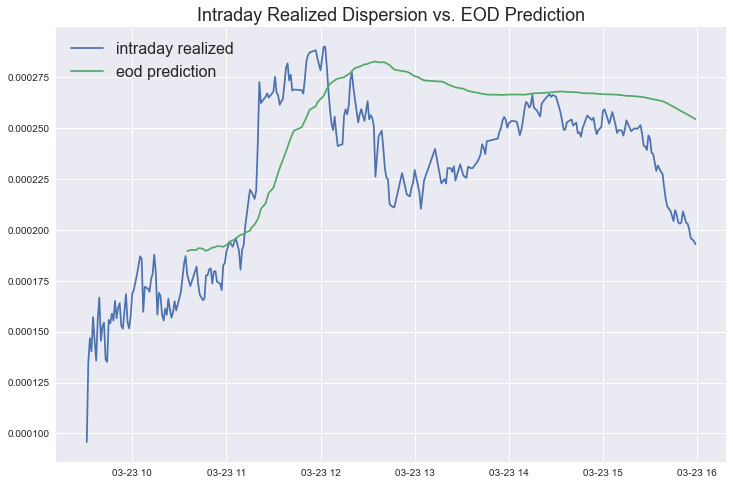

In [526]:
plot(disp.index, disp, label='intraday realized')
plot(pred[30:], label='eod prediction')

title('Intraday Realized Dispersion vs. EOD Prediction', fontsize=18)
legend(loc='upper left', fontsize=16);

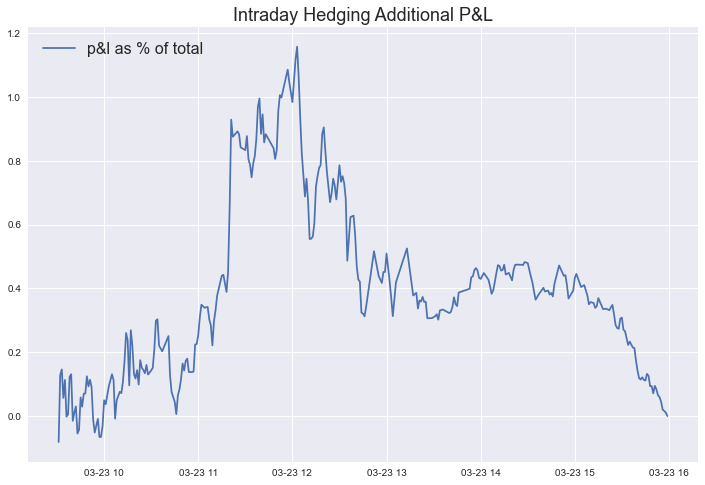

In [527]:
pnls = hedge_pnl(day)
plot(pnls.index, pnls/disp[-1], label='p&l as % of total')

title('Intraday Hedging Additional P&L', fontsize=18)
legend(loc='upper left', fontsize=16);

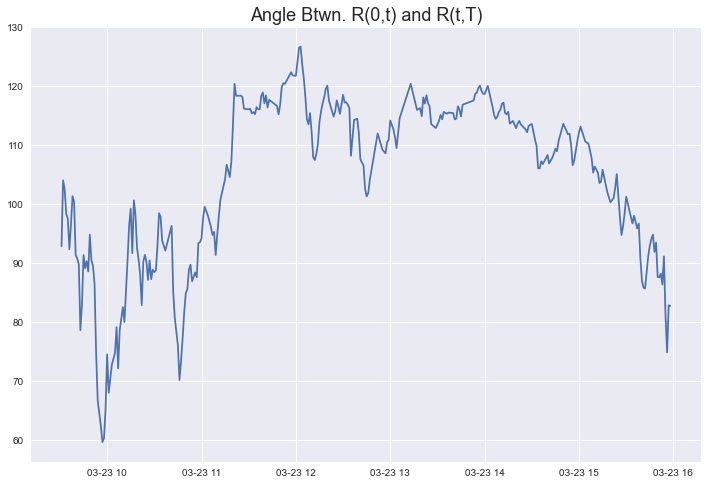

In [528]:
plot(theta.index, theta*180/pi)
title('Angle Btwn. R(0,t) and R(t,T)', fontsize=18);

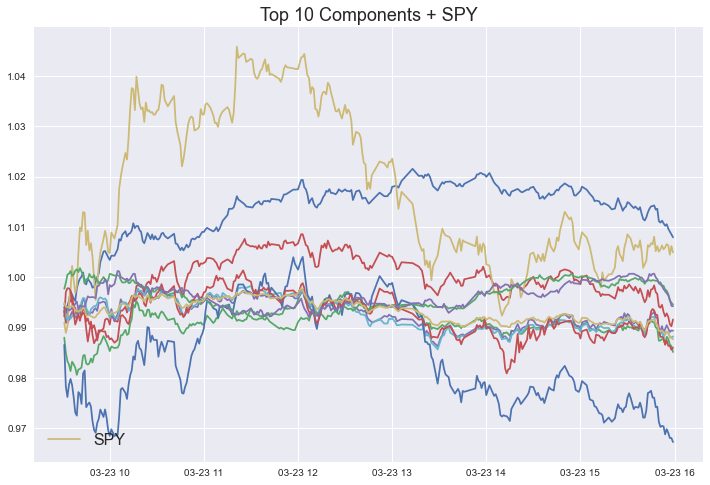

In [529]:
plot(day.index, day.iloc[:,:10])
plot(day.index, day.SPY, label='SPY')
title('Top 10 Components + SPY', fontsize=18)
legend(loc='lower left', fontsize=16);

In [536]:
disps  = {}
preds  = {}
thetas = {}
slopes = {}
pnls   = {}
for date in tqdm.tqdm(df.groupby(df.index.date).first().index[1:]):
    day = slice_day(df, date.strftime('%Y-%m-%d'))
    if len(day.loc[day.index.time == datetime.time(15,59)]) == 0:
        continue
    if len(day.loc[day.index.time == datetime.time(9,32)]) == 0:
        continue
    day = day.loc[day.index.time >= datetime.time(9,32)]
    t = (day.index - day.index[0]).total_seconds() / (day.index[-1] - day.index[0]).total_seconds()
    disp, pred, slope, theta = fit_dispersion(day)
    pnl = hedge_pnl(day)
    pnl.index = t
    disp.index = t
    pred.index = t[30:]
    slope.index = t[30:]
    theta.index = t[:-1]
    pnls[date] = pnl
    disps[date]  = disp
    preds[date]  = pred
    thetas[date] = theta
    slopes[date] = slope

/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/isaacdrachman/anaconda3/lib/python3.7/site-packages/p

In [538]:
disps = pd.DataFrame(disps)
preds = pd.DataFrame(preds)
pnls  = pd.DataFrame(pnls)
thetas = pd.DataFrame(thetas)

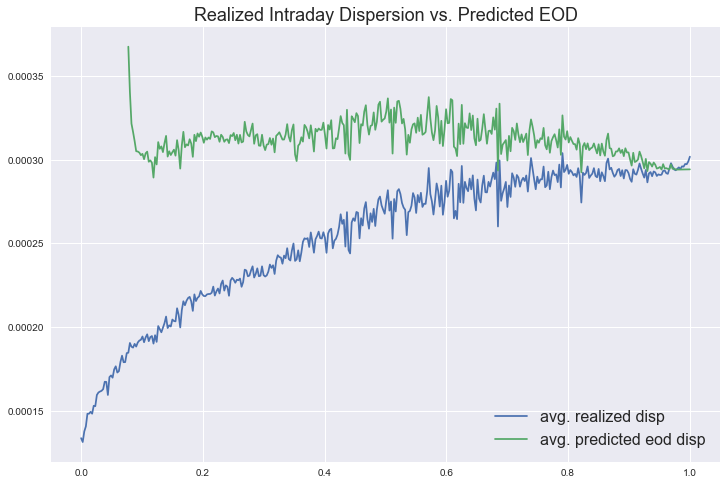

In [542]:
plot(disps.mean(axis=1), label='avg. realized disp')
plot(preds.mean(axis=1), label='avg. predicted eod disp')
title('Realized Intraday Dispersion vs. Predicted EOD', fontsize=18);
legend(loc='lower right', fontsize=16);

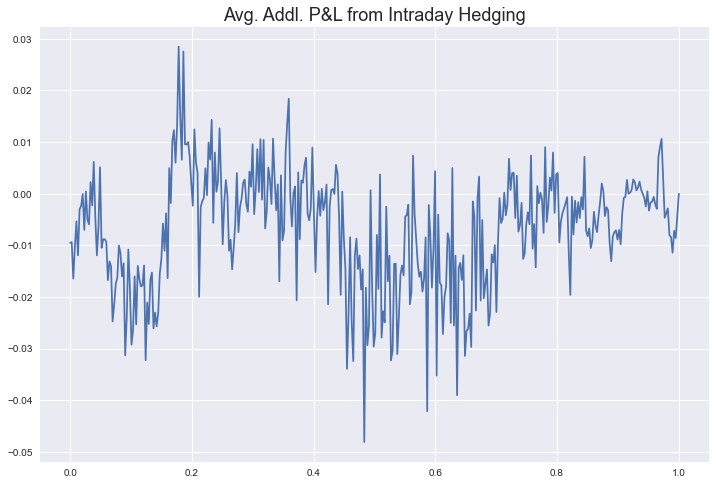

In [543]:
plot(pnls.mean(axis=1)/disps.mean(axis=1).iloc[-1])
title('Avg. Addl. P&L from Intraday Hedging', fontsize=18);

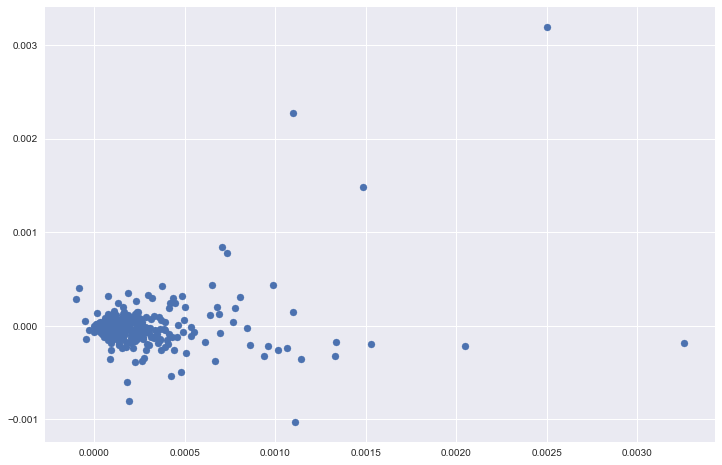

In [553]:
scatter(disps.iloc[len(disps) // 5].dropna(), pnls.iloc[len(disps) // 5].dropna())